# Synthetaic COVID-19 CNN Demo

As an artificial intelligence technology company, we feel it's our duty to provide datasets, AI tools, and predictive analytics that are relevant to the current COVID-19 crisis. Our aims are to catalyze other AI and modeling developments, help researchers analyze the large body of available research, and share visualizations with the general public. If the public is equipped with the accurate information about the spread of COVID-19, we are convinced that many will take action to prevent its spread.

Disclaimer: This tool is for research and educational purposes only and is not intended to be a tool for decision-making. There are many uncertainties and debates about the details of COVID-19 infection and transmission and there are many limitations in any modeling approach. Please talk to your primary care physician if you experience symptoms of COVID-19. 

In [1]:
# Import necessary libraries
import argparse
import math
import random
import os
import shutil
import time
import warnings
import multiprocessing as mp
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import PIL
from tqdm import tqdm
from mlxtend.plotting import plot_confusion_matrix
import numpy as np
from sklearn.metrics import confusion_matrix
import pandas as pd

import torch
from torch import nn, autograd, optim, utils  
from torch.nn import functional as F
from torch.nn import parallel
import torch.utils.data as data
from torch.utils.data import distributed as dist
import torch.multiprocessing as mp
import torch.backends.cudnn as cudnn
from torchvision import transforms, utils, datasets, models
from torch.utils.tensorboard import SummaryWriter
import seaborn as sns
import torchvision

import kornia
from kornia.losses import FocalLoss

/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:544: FutureWa

# Global Variables Initializer 

### Project-specific variables<br>
`var_proj_name` - Project name for the neural network.<br>
`var_arch` - Neural Network architecture to use. Spelling sensitive. {resnet18, resnet50, resnet101, densenet121, densenet169, resnext50_32x4d, mobilenet_v2}<br>
`var_size` - Input size dimension of the data. Must be size x size and Inception V3 requires 299x299 default: 224x224<br>
`var_dataset_path` - Path to chest scan dataset folder. Folder must be set up like Pytorch's ImageFolder. default: './data/xrayscans/'<br>

### Session-specific variables<br>
`var_ckp` - Which checkpoint to continue training from or test. default: None<br>
`var_start_iter` - What iteration to continue from if training is continued. default: 0<br>
`var_iter` - How many total training iteration or epochs to perform if early stopping does not occur. default: 100<br>
`var_batch_size` - Batch size. default: 64<br>
`var_output` - The number of lung diagnosis classs {COVID-19, normal, pneumonia}. default: 3<br>
`var_optimizer` - Optimizer to use {adam, sgd, rmsprop}. default: adam<br>

#### Focal Loss specific variables <br>
`var_use_focal` - Set to True if focal loss is to be used. default: False <br>
`var_alpha` - Alpha hyperparameter for Focal Loss. default: 0.5 <br>
`var_gamma` - Gamma hyperparameter for Focal Loss. default: 2<br>
`var_reduction` - Reduction method for batch losses. default: mean<br>

#### Staged-Transfer Training Protocol Specific variables
`var_use_staged_tt` - Set to True if multiple stages of unfreezing or traditional fitting of last FC layer. default: True <br>
`var_stage_limit` - Maximum amount of stages to occur. Limit may not be met due to early stopping or network size is too small. default: 3 <br>
`var_stage_plateau` - How many iterations to wait for improvements to valid loss until next stage of transfer training occurs. default: 10 <br>
`var_network_ratio` - Ratio of the network to unfreeze after every stage. Unfreezes from the last unfrozen layer from the end. `var_network_ratio * var_stage_limit` must be equal to or less than 1.0. default: 0.1 <br>
`var_use_change_factor` - Set to True if change factor is to be used as the updating learning rate factor. `change_factor = var_lr_factor ^ cur_stage` default: True<br>
`var_change_style` - Method to update the learning rate factor at each stage {compounding, steady} `current_learning_rate = change_factor * or + current_learning_rate`. default: compounding<br>
`var_lr_factor` - The factor to update the learning rate. `LR = LRF * LR` where LRF is `change_factor * stage_count * var_lr_factor` default: 0.1<br>
`var_lr` - Learning rate for training. default: 0.002 <br>
`var_weight_decay` - Weight decay for training. default: 1e-4<br>
`var_reduce_lr` - Set to True if a learning rate scheduler is to be implement. Reduces learning rate after `var_lr_plateau` iterations have occured without a lower loss.<br>
`var_lr_plateau` - Plateau patience value for learning rate scheduler. <br>

__Traditional Transfer Training where all weights are frozen except for the last FC layer and fitted, and then all weights are unfrozen and network is fitted options are available by toggling `var_use_staged_tt` to False.__

### System-specific variables<br>
`var_device` - 'cuda' if using gpu or 'cpu' if using cpu. default:'gpu'<br>
`var_gpus` - List of gpu ids to use for data parallel training. default: [0,1]<br>
`var_distributed` - Feature requirement enables distributed training. default: False<br>
`is_notebook` - Boolean to be used when this notebook is in python scirpt version.


### Directory should appear like this.
```
Demo
|___Covid19Demo.ipynb
|___data
    |___xrayscans
        |___train
        |   |____pneumonia
        |   |____normal
        |   |____COVID-19
        |____test
             |____pneumonia
             |____normal
             |____COVID-19

```

In [2]:
# Project specific variables
var_proj_name = 'Default'
var_arch = 'resnet18'

var_size = 299 if var_arch == 'inception_v3' else 512
var_dataset_path = '~/data/data_v3/'
var_output = 3


# Session specific variables
# var_ckpt = '/data/AAA_Corona/Code/Git/covidresnet18ckptsV1/resnet18v3/32model_bestLOSS0_2267882215338237.pt'
var_ckpt = None
var_start_iter = 0
var_iter = 10
var_batch_size = 64
var_optimizer = 'adam'

var_use_focal = False
var_alpha = 0.5
var_gamma = 5
var_reduction ='mean'

# Staged-Transfer Training specific variables
var_use_staged_tt = False
var_stage_limit = 3
var_stage_plateau = 10
var_network_ratio = 0.1
var_use_change_factor = True
var_change_style = 'compounding'
var_lr_factor = 0.1

# # Traditional Transfer Training specific variables (Uncomment to use)
# var_use_staged_tt = False
# var_stage_limit = 1
# var_stage_plateau = 1
# var_network_ratio = 1.0
# var_use_change_factor = True
# var_change_style = 'compounding'
# var_lr_factor = 0.1


var_lr = 5e-4
var_weight_decay = 1e-4
var_reduce_lr = True
var_stage_plateau = 1
var_lr_plateau = 5
var_end_plateau = 1

# System specific variables
var_device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
var_gpus = [0,1]
var_distributed = False

is_notebook = True
# Append miscelanneous variables
# var_eval = True

## Convert to Python Script
This jupyter was converted to a python file in order to be ran on a server with terminal arguments. This is helpful when for example hyperparameter searching requires many iterations to narrow down the best options. Editing arguments in the terminal is easier than editing code in jupyter notebook. <br>
To convert this notebook to a python script proceed with the following steps:<br>
- Comment the cell above which initializes the project's settings.
- Uncomment the cell above which enables the argument parser and sets the is_script to True which will remove GUI plots.

In [3]:
# if __name__ == '__main__':
#     parser = argparse.ArgumentParser()
#     parser.add('data', default='./data_folder', type=str, help='Path to the folder containing the training images.')
#     parser.add('--proj-name', default='default', type=str, help='Project name for the neural network.')
#     parser.add('--arch', default='resnet18',  type=str, help='Neural network architecture to choose from {resnet18, resnet50, resnet101, densenet121, densenet169, resnext50_32x4d, mobilenet_v2, inception_v3}')
#     parser.add('--size', default=512, type=int, help='Size of the input image. Must be square (height == width)')
#     parser.add('--output', default=3, type=int, help='Number of output classes for transfer training. {COVID-19, normal, pneumonia}')
#     parser.add('--evaluate', default=False, action='store_true', help='Use network evaluation mode.')
#     parser.add('--ckpt', default=None, type=str, help='Path to network checkpoint for metric evaluation.')
#     parser.add('--iters',  default=200, type=int, help='Number of iterations to train for.')
#     parser.add('--start-iter', default=0, type=int, help='Iteration to start at. For continued training.')
#     parser.add('--batch-size', default=64, type=int, help='Batch size for training and evaluating.')
#     parser.add('--optimizer', default'adam', type=str, help='Optimizer to use for training. {sgd, adam, rmsprop}')
#     parser.add('--lr', default=0.0002, type=float, help='Learning Rate for training.')
#     parser.add('--weight-decay', default=1e-4, type=float, help='Weight Decay for training.')
#     parser.add('--gpus', default='0', type=str, help='String of GPUs to use deliminated by a comma. Default is to use all available GPUs. IE: 2 GPUs 3,4 --gpus="3,4"')
#     parser.add('--distributed', default=False, action='store_true')
    
#     parser.add('--use-focal', default=False, action='store_true', help='Use focal loss. Alpha, Gamma, and reduction method can be set.')
#     parser.add('--focal-alpha', default=0.5, type=float, help='Alpha hyperparameter for focal loss.')
#     parser.add('--focal-gamma', default=2, type=int, help='Gamma hyperparameter for focal loss.')
#     parser.add('--focal-reduction', default='mean', type=str, help='Reduction method to apply for batch loss. {none, mean, sum}')
    
#     parser.add('--use_staged_tt', default=False, action='store_true', help='Use Staged Transfer Training Protocol.')
#     parser.add('--stage-limit', default=3, type=int, help='Total count of stages to unfreeze for transfer training.')
#     parser.add('--plateau-patience', default=10, type=int, help='Number of iterations without lower valid loss until moving to the next stage of transfer training.')
#     parser.add('--network-ratio', default=0.2, type=float, help='Percentage of the network to unfreeze at every stage.')
#     parser.add('--change-factor', default='exponential', type=str, help='Method to update the change factor as the stages progress. {exponential, linear}')
#     parser.add('--change-style', default='compounding', type=str, help='Method to update the training learning rate. {compounding, steady}')
#     parser.add('--lr-factor', default=0.1, type=float, help='Base hyperparameter lr factor.  ')
    
    
#     args = parser.parse_args()

# # Project specific variables
# var_proj_name = args.proj_name
# var_arch = args.arch
# var_size = 299 if var_arch == 'inception_v3' else args.size
# var_dataset_path = args.data
# var_output = args.output


# # Session specific variables
# # var_ckpt = '/data/AAA_Corona/Code/Git/COVID19-Chest-xrays/RippedDiscriminator/checkpoints/resnet18v5/3model_bestLOSS0_262ACC0_88.pt'
# var_ckpt = args.ckpt
# var_start_iter = args.start_iter
# var_iter = args.iters
# var_batch_size = args.batch_size
# var_lr = args.lr
# var_weight_decay = args.weight_decay
# var_optimizer = args.optimizer
# var_use_focal = args.use_focal
# if var_use_focal:
#     var_alpha = args.focal_alpha
#     var_gamma = args.focal_gamma
#     reduction_methods = ['none', 'mean', 'sum']
#     var_reduction = args.focal_reduction if args.focal_reduction in reduction_methods else 'mean'

# # Transfer Training specific variables
# var_use_staged_tt = args.use_staged_tt
# var_stage_limit = 3
# var_stage_plateau = 10
# var_network_ratio = 0.2
# var_change_factor = 'exponential'
# var_change_style = 'compounding'
# var_lr_factor = .1
    
# # System specific variables
# var_gpus = [int(gpu) for gpu in var.gpus.split(',')]
# var_device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# var_distributed = False

# is_notebook = False
# # Append miscelanneous variables
# # var_eval = True

# Create Project folders
Automatically checks whether there is a project with the `var_proj_name` and creates the appropriate project directory if there exists none, else it modifies the `var_proj_name` by appending an underscore and a digit. IE: `proj_1`<br>


This means `var_proj_name` cannot contain an underscore. This is so a previous runs checkpoints are accidently overwritten.<br><br>

Creates the subfolders used for storing metrics and logging.
<br>
Here are what each project subfolders contains.<br>
- `cms` : Holds image plots of the confusion matrix of the test set.<br>
- `graphs` : Holds image plots of the accuracy and loss for training and validation sets. <br>
- `logs` : Contains the tensorboard log files which can be opened up in Tensorboard to analyze. <br>

### Directory should appear like this.
```
Demo
|___Covid19Demo.ipynb
|___data
|___checkpoints
    |___proj_1
    |   |___cms
    |   |___graphs
    |   |___logs
    |
    |___proj_2
        |___cms
        |___graphs
        |___logs
```
<br>

In [4]:
cur_dir = os.getcwd()
ckpt_dir = os.path.join(cur_dir, 'checkpoints_fin')
if os.path.exists(ckpt_dir) is False:
    os.makedirs(ckpt_dir, exist_ok=True)
    
while os.path.exists(os.path.join(ckpt_dir, var_proj_name)):
    proj_ver = var_proj_name.split('_')
    if len(proj_ver) == 1:
        var_proj_name += '_1'
    else:
        next_ver = str(int(proj_ver[1]) + 1)
        var_proj_name = '{}_{}'.format(proj_ver[0], next_ver)
        
proj_ckpt = os.path.join(ckpt_dir, var_proj_name)
if os.path.exists(proj_ckpt) is False:
    os.makedirs(proj_ckpt, exist_ok=True)
    
log_dir = os.path.join(proj_ckpt, 'logs')
if os.path.exists(log_dir) is False:
    os.makedirs(log_dir, exist_ok=True)

cm_dir = os.path.join(proj_ckpt, 'cms')
if os.path.exists(cm_dir) is False:
    os.makedirs(cm_dir, exist_ok=True)
    
graph_dir = os.path.join(proj_ckpt, 'graphs')
if os.path.exists(graph_dir) is False:
    os.makedirs(graph_dir, exist_ok=True)


## Data Utility Helper Function Set Up
Some helper functions that will help later.<br>
Initialize Tensorboard for logging of loss and accuracy. 

In [5]:
def data_sampler(dataset, shuffle, distributed):
    if distributed:
        return data.distributed.DistributedSampler(dataset, shuffle=shuffle)

    if shuffle:
        return data.RandomSampler(dataset)
    else:
        return data.SequentialSampler(dataset)

# Create directory for tensorboard logs.
writer = SummaryWriter(log_dir)

# Data Preprocessing
The often-updated COVID-19 dataset consists of pneumonia, normal, and COVID-19 chest xray scans from AP and PA views.<br>

Images are resized and square cropped. The samples are then normalized according to Imagenet.

### Image Augmentation and Transformations.
In order to compensate for the small number of training samples, it has been found to be helpful to add data augmentation to help the training process. <br><br>
Initially, default transformations are simple resize and crop. <br>
Normalization must be done because the pretrained weights were trained on imagenet normalized to the specified range.

In [6]:
train_transform = transforms.Compose(
    [
        transforms.Resize((var_size, var_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=(0.9, 1.1)),
        transforms.RandomAffine(degrees=10,translate=(0.1,0.1)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),    
    ])

val_transform = transforms.Compose(
    [
        transforms.Resize((var_size, var_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),    
    ])

test_transform = transforms.Compose(
    [
        transforms.Resize((var_size, var_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])

### Create Datasets
From the test and train subfolders of the `var_dataset_path` variable, create their respective Pytorch dataset class. 

In [7]:
train_path = os.path.join(var_dataset_path, 'train')
val_path = os.path.join(var_dataset_path, 'val')
test_path = os.path.join(var_dataset_path, 'test')

train_dataset = datasets.ImageFolder(train_path, transform=train_transform)
val_dataset = datasets.ImageFolder(val_path, transform=val_transform)
test_dataset = datasets.ImageFolder(test_path, transform=test_transform)


### Create Pytorch Dataloader
Create a dataloader for each of the datasets. <br>
Default implementation does not take advantage of multiprocessing. In order to take advantage of multiprocessing and the requirements are met, then do not run the next cell code. <br>
Comment the next cell, and uncomment the cell after the next cell to fully use multiple workers.

In [8]:
# train_dataloader = data.DataLoader(
#     train_dataset,
#     batch_size=var_batch_size,
#     sampler=data_sampler(train_dataset, shuffle=True, distributed=var_distributed),
# )

# val_dataloader = data.DataLoader(
#     val_dataset,
#     batch_size=var_batch_size,
#     sampler=data_sampler(val_dataset, shuffle=False, distributed=var_distributed),
# )

In [9]:
# UNCOMMENT THIS CODE if multiple workers are to be used for dataloaders.

workers = math.floor(mp.cpu_count() * 0.75) if mp.cpu_count() >= 2 else 1
print('Using {} workers for dataloaders.'.format(str(workers)))

# The order in which the dataloader presents to the network the training data is one source of randomness which separates this run from other runs.
train_dataloader = data.DataLoader(
    train_dataset,
    batch_size=var_batch_size,
    sampler=data_sampler(train_dataset, shuffle=True, distributed=var_distributed),
    num_workers=workers,
)

val_dataloader = data.DataLoader(
    val_dataset,
    batch_size=var_batch_size,
    sampler=data_sampler(val_dataset, shuffle=True, distributed=var_distributed),
    num_workers=workers,
)

test_dataloader = data.DataLoader(
    test_dataset,
    batch_size=var_batch_size,
    sampler=data_sampler(test_dataset, shuffle=True, distributed=var_distributed),
    num_workers=workers
)

Using 18 workers for dataloaders.


### Visualize Scan Images of Training, Val, and Test sets
View a small subsample of your training and test set to observe what they look like.

In [10]:
#function to return key for any value 
def get_key(val): 
    for key, value in train_dataset.class_to_idx.items(): 
         if val == value: 
            return key 
        
# function to obtain label counts
def dataset_distribution(dataset):
    dist = {'COVID-19':0,'normal':0,'pneumonia':0}
    
    for i in range(len(dataset)):
        if get_key(dataset[i][1]) == "COVID-19":
            dist['COVID-19'] +=1
        elif get_key(dataset[i][1]) == "normal":
            dist['normal'] +=1
        else:    
            dist['pneumonia'] +=1
    return dist

In [11]:
# # print out some data stats
# print('Number of training images: ', len(train_dataset))
# print('Number of validation images: ', len(val_dataset))   
# print('Number of testing images: ', len(test_dataset))   

# print('Number of classes: ', len(train_dataset.classes))
# print('Name of classes: ', train_dataset.classes)
# print('Labels: ', train_dataset.class_to_idx)

# train_dist = dataset_distribution(train_dataset)
# print('Training set Distribution: {}'.format(train_dist))
# val_dist = dataset_distribution(val_dataset)
# print('Validation set Distribution: {}'.format(val_dist))
# test_dist = dataset_distribution(test_dataset)
# print('Testing set Distribution: {}'.format(test_dist))

# # Analyzing the shape of one batch
# train_images, train_labels = next(iter(train_dataloader))
# val_images, val_labels = next(iter(val_dataloader))
# test_images, test_labels = next(iter(test_dataloader))

# print('Shape of first batch of training images: ', train_images.shape)
# print('Shape of first batch of validation images: ', val_images.shape)
# print('Shape of first batch of testing images: ', test_images.shape)

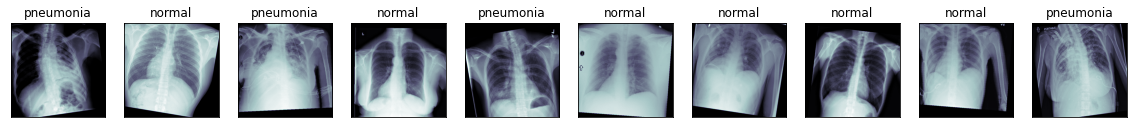

In [12]:
# obtain one batch of training images
dataiter = iter(train_dataloader)
images, labels = dataiter.next()

# plot the images in the batch, along with the corresponding labels
if is_notebook:
    fig = plt.figure(figsize=(20, 20))
    for idx in np.arange(10):
        ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
        plt.imshow(images[idx][0].numpy().squeeze(), cmap='bone')
        ax.set_title(train_dataset.classes[int(labels[idx])])

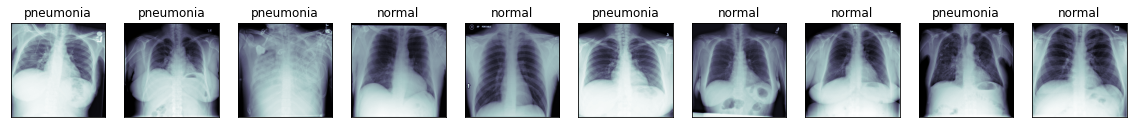

In [13]:
# obtain one batch of VAL images
dataiter = iter(val_dataloader)
images, labels = dataiter.next()

# plot the images in the batch, along with the corresponding labels
if is_notebook:
    fig = plt.figure(figsize=(20, 20))
    for idx in np.arange(10):
        ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
        plt.imshow(images[idx][0].numpy().squeeze(), cmap='bone')
        ax.set_title(val_dataset.classes[int(labels[idx])])

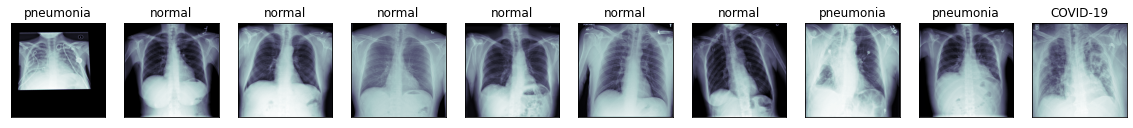

In [14]:
# obtain one batch of TEST images
dataiter = iter(test_dataloader)
images, labels = dataiter.next()

# plot the images in the batch, along with the corresponding labels
if is_notebook:
    fig = plt.figure(figsize=(20, 20))
    for idx in np.arange(10):
        ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
        plt.imshow(images[idx][0].numpy().squeeze(), cmap='bone')
        ax.set_title(test_dataset.classes[int(labels[idx])])

## Model Utility Helper Function Set Up
Create functions which will help save time later. <br><br>
`get_named_model(arch, pretrained)` : Helper function to encapsulate switch-like behavior for architecture choice. <br><br>
`modify_model(model, arch, channels)` : Helper function to help modify model for transfer training on new objective. <br>

- Transfer training involves freezing the learned weights of a pretrained networks' convolution filters.<br>

- As well as replacing the last classifier or fully connected layer with a new classifier or fully connected layer.<br>

- These weights are not frozen. By default, initializing layers automatically sets `requires_grad` to true.<br>




In [15]:
def get_named_model(arch, pre):
    if arch == 'resnet18':
        return models.resnet18(pretrained=pre)
    elif arch == 'resnet50':
        return models.resnet50(pretrained=pre)
    elif arch == 'resnet101':
        return models.resnet101(pretrained=pre)
    elif arch == 'resnet152':
        return models.resnet152(pretrained=pre)
    elif arch == 'wideresnet50':
        return models.wide_resnet50_2(pretrained=pre)
    elif arch == 'wideresnet101':
        return models.wide_resnet101_2(pretrained=pre)
    elif arch == 'densenet121':
        return models.densenet121(pretrained=pre)
    elif arch == 'densenet169':
        return models.densenet169(pretrained=pre)
    elif arch == 'densenet201':
        return models.densenet201(pretrained=pre)
    elif arch == 'resnext50_32x4d':
        return models.resnext50_32x4d(pretrained=pre)
    elif arch == 'resnext101_32x8d':
        return models.resnext101_32x8d(pretrained=pre)
    elif arch == 'mobilenet_v2':
        return models.mobilenet_v2(pretrained=pre)


def modify_model(model, arch, channels, adjust):
    count = 0
    for parameter in model.parameters():
        parameter.requires_grad = False
        count += 1
        
    if adjust:
        if "densenet" in arch:
            in_feature = model.classifier.in_features
            model.classifier = nn.Linear(in_features=in_feature, out_features=channels)
        elif arch == 'mobilenet_v2':
            in_feature = model.classifier[1].in_features
            model.classifier = nn.Sequential(*[nn.Dropout(0.2), nn.Linear(in_feature, channels)])
        else:
            in_feature = model.fc.in_features
            model.fc = nn.Linear(in_features=in_feature, out_features=channels)

    return model, count

def get_optimizer(optimizer_option, model, lr, wd):
    optimizer = None
    if optimizer_option == 'sgd':
        optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay=wd)
    elif optimizer_option == 'rmsprop':
        optimizer = optim.RMSprop(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay=wd)
    else:
        optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay=wd)
    return optimizer

## Load Network
If `var_ckpt` is not None, then a model checkpoint was given. The steps to loading a neural network for continued training are : <br>
- Create the base network.
- Modify the base network to have the same output class.
- Load the model checkpoint and fill in the network with the retrieved pretrained weights. 
<br>

#### Important:
In contrast to the other models the inception_v3 expects tensors with a size of N x 3 x 299 x 299, so ensure your images are sized accordingly.<br>



In [16]:
if var_ckpt and os.path.exists(var_ckpt):
    try:
        ckpt = torch.load(var_ckpt)
    except:
        print('Checkpoint failed to load. Loading default network.')
        model = get_named_model(var_arch, True)
        model, layer_count = modify_model(model, var_arch, var_output, True)
    else:
        print('Checkpoint successfully loaded. Network ready for training.')
        model, layer_count = modify_model(model, var_arch, var_output, False)
else:
    model = get_named_model(var_arch, True)
    model, layer_count = modify_model(model, var_arch, var_output, True)
    

### Modify model for multi-GPU processing
Modify model to become a `DataParallel` class which allows a batch
in the `DataLoader` class to be split across available GPUs in the list specified by `device_ids`. <br>

Move model to GPU.

In [17]:
# Detects if you have 2 GPUs and whether you specified two in system by checking the length of the gpu list.
if len(var_gpus) > 1 and len(var_gpus) <= torch.cuda.device_count():
    model = nn.DataParallel(model, device_ids=var_gpus)
    print(torch.cuda.device_count())
    
model = model.to(var_device)
cuda_availability = torch.cuda.is_available()

if cuda_availability:
    print('Using GPU : {}'.format(var_device))
else:
    print('Using CPU : {}'.format(var_device))
    
with open(os.path.join(proj_ckpt, '{}_arch.txt'.format(var_proj_name)), 'w') as f:
    print(model, file=f)
    f.close()

2
Using GPU : cuda


# Training Loop for One Epoch
This function represents the training that occurs within one epoch or iteration. Training through all batches and images of the training dataloader represents one epoch or iteration.
<br>
The loss is recorded in Tensorboard. The current cumulative accuracy and loss for one epoch is also recorded. 

In [18]:
def train_loop(train_loader, train_len, model, criterion, eval_criterion, optimizer, epoch, var_device):
    t_t_start = time.time()
    
    train_loss = 0.0
    comp_loss = 0.0
    train_accuracy = 0.0
    pic_count = 0
    
    
    model.train()
    for i, (images, target) in enumerate(train_loader):
        if cuda_availability:
            images = images.to(var_device)
            target = target.to(var_device)

        pic_count += images.size(0)

        output = model(images)
        loss = criterion(output, target)
        compare_loss = eval_criterion(output, target)
    
        
        train_loss += loss.item()*images.size(0)
        comp_loss += compare_loss.item()*images.size(0)
        top_p, top_class = output.topk(1, dim=1)
        equals = top_class == target.view(*top_class.shape)
        train_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()*images.size(0)
        
        current_training_loss = train_loss / pic_count
        current_comp_loss = comp_loss / pic_count
        current_training_accuracy = (train_accuracy / pic_count ) * 100

        writer.add_scalar('weighted_ce_loss/training', current_training_loss, epoch * len(train_loader) + i)
        writer.add_scalar('accuracy/training', current_training_accuracy, epoch * len(train_loader) + i)
        writer.add_scalar('ce_loss/training', current_comp_loss, epoch * len(train_loader) + i)
            
        # compute gradient and do optimizer step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
                
        if i % 10 == 0:
            print('{}:{}  Avg Training Loss: {:.3f}  Avg Training Accuracy: {:.8f}'.format(str(epoch), i, current_training_loss, current_training_accuracy))
    
    f_t_end = time.time() - t_t_start
            
    return train_loss, train_accuracy, comp_loss, pic_count, f_t_end


# Validation Loop for One Epoch
Validation loop is ran after each training session in order to evaluate the performance of the neural network after training.
<br>
The loss is recorded in Tensorboard. The current cumulative accuracy and loss for one epoch is also recorded. 

In [19]:
def validate_loop(val_dataloader, val_len, model, criterion, eval_criterion, epoch, var_device):
    t_t_start = time.time()

    valid = 0.0
    val_accuracy = 0.0
    val_pic_count = 0
    ce = 0.0
    
    model.eval()
    for i, (images, target) in enumerate(val_dataloader):
        if cuda_availability:
            images = images.to(var_device)
            target = target.to(var_device)

        val_pic_count += images.size(0)

        output = model(images)
        loss = criterion(output, target)
        ce_loss = eval_criterion(output, target)
        
        valid += loss.item()*images.size(0)
        ce += ce_loss.item()*images.size(0)
        
        top_p, top_class = output.topk(1, dim=1)
        equals = top_class == target.view(*top_class.shape)
        val_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()*images.size(0)
        current_accuracy = (val_accuracy / val_pic_count ) * 100
        valid_avg = (valid / val_pic_count)

        writer.add_scalar('weighted_ce_loss/val', valid_avg, epoch * len(val_dataloader) + i)
        writer.add_scalar('accuracy/val', current_accuracy, epoch * len(val_dataloader) + i)

        print('{}:{}  Avg Val Loss: {:.3f}  Avg Val Accuracy: {:.8f}'.format(str(epoch), i, valid_avg, current_accuracy))

    f_t_end = time.time() - t_t_start

    return valid, val_accuracy, ce, val_pic_count, f_t_end

# Graphing Loss and Accuracy Metrics
View and analyze the training and testing metrics for loss and accuracy. This function is called when validation loss tapers. <br>
TODO: Save graphs.

In [20]:
def create_metric_graphs(train_loss_track, valid_loss_track, train_acc_track, valid_acc_track, epoch):
    plt.plot(train_loss_track, label='Training loss')
    plt.plot(valid_loss_track, label='Validation loss')
    plt.legend(frameon=False)
    
    fig_loss = str(epoch) + 'loss.png'
    fig_path = os.path.join(graph_dir, fig_loss)
    plt.savefig(fig_path)
    plt.show()

    plt.plot(train_acc_track, label='Training acc')
    plt.plot(valid_acc_track, label='Validation acc')
    plt.legend(frameon=False)

    fig_acc = str(epoch) + 'acc.png'
    fig_path = os.path.join(graph_dir, fig_acc)
    plt.savefig(fig_path)
    plt.show()



# Visualizing Predictions With Confusion Matrix
Visualize the network's accuracy and performance on classification of the three class networks via Confusion Matrix.<br>
TODO: Save Confusion Matrix.

In [21]:
def create_confusion_matrix(epoch):
    test_classes = val_dataset.classes
    test_loss = 0.0
    class_correct = list(0. for i in range(len(test_classes)))
    class_total = list(0. for i in range(len(test_classes)))
    actual_labels = []
    pred_labels = []
    missclassified_imgs = []
    model.eval()
    for index, (data, target) in enumerate(val_dataloader):
        if cuda_availability:
            data = data.to(var_device)
            target = target.to(var_device)

        output = model(data)
        loss = criterion(output, target)
        test_loss += loss.item()*data.size(0)

        output = output.detach().cpu()
        top_p, top_class = output.topk(1, dim=1)

        target = target.cpu()
        equals = top_class == target.view(*top_class.shape)

        for i in range(len(target)):
            label = target.data[i]
            class_correct[label] += equals[i].item()
            class_total[label] += 1

        misscls_idx = np.argwhere(equals == False)[0]
        data = data.cpu()
        for i in misscls_idx:
            missclassified_imgs.append((data[i],target[i],top_class[i]))

        actual_labels.extend(target)
        pred_labels.extend(top_class.view(*target.shape))


    # average test loss
    test_loss = test_loss/len(val_dataloader.dataset)
    print('Test Loss: {:.6f}\n'.format(test_loss))

    cm = confusion_matrix(actual_labels,pred_labels)
    print(cm)
    
    class_names = val_dataset.classes
    if is_notebook:
        fig, ax = plot_confusion_matrix(conf_mat=cm,
                                        colorbar=True,
                                        show_absolute=True,
                                        class_names=class_names)
        plt.title('Epoch {} Loss {} : Confusion Matrix'.format(str(epoch), str(test_loss)))
        plt.savefig(os.path.join(cm_dir, '{}ConfusionMatrix.png'.format(str(epoch))))
        plt.show()
        
    for i in range(len(test_classes)):
        if class_total[i] > 0:
            recall = cm[i][i] / (cm[i][0] + cm[i][1] + cm[i][2])
            precision = cm[i][i]/ (cm[0][i] + cm[1][i] + cm[2][i])
        
            f1 = (2.*precision*recall)/(precision+recall)
            
            print('Test Accuracy/Sensitivity of {}: {:.2f}% ({}/{})'.format(test_classes[i], 100 * class_correct[i] / class_total[i], np.sum(class_correct[i]), np.sum(class_total[i])))
            print('Test Precision of {}: {:.2f}% '.format(test_classes[i], 100*precision))
            print('Test F1 score of {}: {:.2f}% '.format(test_classes[i], 100*f1))
        else:
            print('Test Accuracy/Sensitivity of {}: N/A (no training examples)' % (test_classes[i]))
        
        
    print('\nTest Accuracy (Overall): {:.2f}% ({}/{})'.format(100. * np.sum(class_correct) / np.sum(class_total),
                                                          np.sum(class_correct), np.sum(class_total))) 
    
    return cm[0][0] / (cm[0][0] + cm[0][1] + cm[0][2])

# Where The Magic Happens ~


## Training Settings and Metrics

In [22]:
pbar = range(var_iter)
optimizer = get_optimizer(var_optimizer, model, var_lr, var_weight_decay)

# Training set Distribution: {'COVID-19': 175, 'normal': 7081, 'pneumonia': 4836}
# Max(Number of occurrences in most common class) / (Number of occurrences in rare classes)

covid_weight = (7081.)/(175.)
normal_weight = (7081.)/(7081.)
pneumonia_weight = (7081.)/(4836.)

class_weights = torch.tensor([covid_weight,normal_weight,pneumonia_weight]).to(var_device)

criterion = nn.CrossEntropyLoss(weight=class_weights) if var_use_focal is False else FocalLoss(var_alpha, var_gamma, var_reduction)
#criterion = nn.CrossEntropyLoss() if var_use_focal is False else FocalLoss(var_alpha, var_gamma, var_reduction)
eval_criterion = nn.CrossEntropyLoss()

scheduler = None
if var_reduce_lr:
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=var_lr_plateau)
    
# Track some metrics for the current training session
val_best_acc = 0
val_best_loss = np.Inf
current_index = 0
train_loss_track = []
valid_loss_track = []
train_acc_track = []
valid_acc_track = []


## Retrieve Class Probabilities.
Retrieves the probability output for all classes and stores the file name, class probabilities, and target in a csv file.

In [23]:
# Prepare helper class to hold data images and file paths.
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    # Extends torchvision.datasets.ImageFolder to return img and file name.

    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [3]:
# TODO: Transform this function into a python script with argument parsers for future use.

def output_class_statistics(val_dataloader, test_dataloader, model, var_device, proj_ckpt, csv_file):
    results = []
    model.to(var_device)
    model.eval()
    k = 0
    class_list = [temp for temp in os.listdir(val_path)]
    columns = 'file'
    for classes in class_list:
        columns += ',{}'.format(str(classes))
        k += 1
    columns += ',target,dsplit'
    results.append(columns)
    
    for i, (images, target, paths) in enumerate(val_dataloader):
        if cuda_availability:
            images = images.to(var_device)
            target = target.to(var_device)
            
        output = model(images)
        sm = torch.nn.Softmax(dim=1)
        output = sm(output)
        
        for img in range(0, images.size(0)):
            answer = '{}'.format(os.path.basename(paths[img]))
            for x in range(0, output.size()[1]):
                answer += ',{:.4f}'.format((output[img][x].item()))
            answer += ',{},{}'.format(str(target[img].item()), 'val')
            results.append(answer)

    for i, (images, target, paths) in enumerate(test_dataloader):
        if cuda_availability:
            images = images.to(var_device)
            target = target.to(var_device)

        output = model(images)
        sm = torch.nn.Softmax(dim=1)
        output = sm(output)

        for img in range(0, images.size(0)):
            answer = '{}'.format(os.path.basename(paths[img]))
            for x in range(0, output.size()[1]):
                answer += ',{:.4f}'.format((output[img][x].item()))
            answer += ',{},{}'.format(str(target[img].item()), 'test')
            results.append(answer)

    with open(os.path.join(proj_ckpt, csv_file), 'w') as f:
        for line in results:
            print(line, file=f)
        f.close()
        
    

In [4]:
def eval_confusion_matrix(model):
    cuda_availability = torch.cuda.is_available()
    
    test_classes = test_dataset.classes
    
    test_loss = 0.0
    class_correct = list(0. for i in range(len(test_classes)))
    class_total = list(0. for i in range(len(test_classes)))
    actual_labels = []
    pred_labels = []
    missclassified_imgs = []
    
    model.eval()
    for index, (data, target) in enumerate(test_dataloader):
        if cuda_availability:
            data = data.to(var_device)
            target = target.to(var_device)

        output = model(data)
        loss = criterion(output, target)
        test_loss += loss.item()*data.size(0)

        output = output.detach().cpu()
        top_p, top_class = output.topk(1, dim=1)

        target = target.cpu()
        equals = top_class == target.view(*top_class.shape)

        for i in range(len(target)):
            label = target.data[i]
            class_correct[label] += equals[i].item()
            class_total[label] += 1

        misscls_idx = np.argwhere(equals == False)[0]
        data = data.cpu()
        for i in misscls_idx:
            missclassified_imgs.append((data[i],target[i],top_class[i]))

        actual_labels.extend(target)
        pred_labels.extend(top_class.view(*target.shape))


    
    # average test loss
    test_loss = test_loss/len(test_dataloader.dataset)
    print('Test Loss: {:.6f}\n'.format(test_loss))

    cm = confusion_matrix(actual_labels,pred_labels)
    print(cm)
    
    class_names = test_dataset.classes
    if is_notebook:
        fig, ax = plot_confusion_matrix(conf_mat=cm,
                                        colorbar=True,
                                        show_absolute=True,
                                        class_names=class_names)
        plt.title('Loss {} : Confusion Matrix'.format(str(test_loss)))
        plt.savefig(os.path.join(cm_dir, 'ConfusionMatrix.png'))
        plt.show()
        
    for i in range(len(test_classes)):
        if class_total[i] > 0:
            recall = cm[i][i] / (cm[i][0] + cm[i][1] + cm[i][2])
            precision = cm[i][i]/ (cm[0][i] + cm[1][i] + cm[2][i])
        
            f1 = (2.*precision*recall)/(precision+recall)
            
            print('Test Accuracy/Sensitivity of {}: {:.2f}% ({}/{})'.format(test_classes[i], 100 * class_correct[i] / class_total[i],
                                                             np.sum(class_correct[i]), np.sum(class_total[i])))
            print('Test Precision of {}: {:.2f}% '.format(test_classes[i], 100*precision))
            print('Test F1 score of {}: {:.2f}%\n '.format(test_classes[i], 100*f1))
        else:
            print('Test Accuracy/Sensitivity of {}: N/A (no training examples)' % (test_classes[i]))
        
        
    print('\nTest Accuracy (Overall): {:.2f}% ({}/{})'.format(100. * np.sum(class_correct) / np.sum(class_total),
                                                          np.sum(class_correct), np.sum(class_total))) 
    

## Run Training

### Transfer Learning Protocol j
Freeze all weights except for the last fully connected and fit the model.


0:0  Avg Training Loss: 1.148  Avg Training Accuracy: 10.93750000
0:10  Avg Training Loss: 1.150  Avg Training Accuracy: 53.69318182
0:20  Avg Training Loss: 1.062  Avg Training Accuracy: 59.00297619
0:30  Avg Training Loss: 1.072  Avg Training Accuracy: 62.80241935
0:40  Avg Training Loss: 1.055  Avg Training Accuracy: 64.51981707
0:50  Avg Training Loss: 1.033  Avg Training Accuracy: 64.92034314
0:60  Avg Training Loss: 1.022  Avg Training Accuracy: 66.57274590
0:70  Avg Training Loss: 1.011  Avg Training Accuracy: 67.60563380
0:80  Avg Training Loss: 1.007  Avg Training Accuracy: 68.32561728
0:90  Avg Training Loss: 0.997  Avg Training Accuracy: 69.07623626
0:100  Avg Training Loss: 0.987  Avg Training Accuracy: 69.30693069
0:110  Avg Training Loss: 0.968  Avg Training Accuracy: 70.56587838
0:120  Avg Training Loss: 0.969  Avg Training Accuracy: 71.24225207
0:130  Avg Training Loss: 0.962  Avg Training Accuracy: 69.83540076
0:140  Avg Training Loss: 0.950  Avg Training Accuracy: 69.

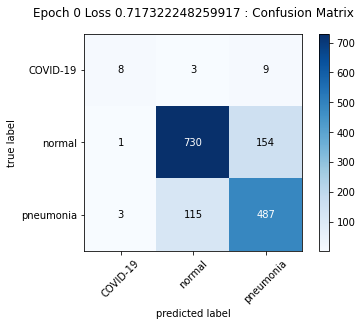

Test Accuracy/Sensitivity of COVID-19: 40.00% (8.0/20.0)
Test Precision of COVID-19: 66.67% 
Test F1 score of COVID-19: 50.00% 
Test Accuracy/Sensitivity of normal: 82.49% (730.0/885.0)
Test Precision of normal: 86.08% 
Test F1 score of normal: 84.25% 
Test Accuracy/Sensitivity of pneumonia: 80.50% (487.0/605.0)
Test Precision of pneumonia: 74.92% 
Test F1 score of pneumonia: 77.61% 

Test Accuracy (Overall): 81.13% (1225.0/1510.0)
Training has completed. Evaluating network performance on test set. Logging network outputs.


IndexError: Caught IndexError in DataLoader worker process 17.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/_utils/worker.py", line 178, in _worker_loop
    data = fetcher.fetch(index)
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/usr/local/lib/python3.6/dist-packages/torchvision/datasets/folder.py", line 137, in __getitem__
    path, target = self.samples[index]
IndexError: list index out of range


In [26]:
train_len = len(train_dataloader)
val_len = len(val_dataloader)
current_best_model = model.state_dict()
current_best_index = 0
logs = []
index = 0
stage_count = 0
last_improved = 0
logs_df = pd.DataFrame(columns=['epoch', 'train_time', 'train_wce', 'train_ce', 'train_accuracy', 'val_time', 'val_wce', 'val_ce', 'val_accuracy'])

while index < var_iter:
    i = index + var_start_iter
    
    # n-stage default: 3-stage Transfer Learning Protocol
    stage_limit = var_stage_limit
    
    # Training has finished
    if i > var_iter or last_improved == var_end_plateau or stage_count == stage_limit:
        print('Training has completed. Evaluating network performance on test set. Logging network outputs.')
        model.load_state_dict(current_best_model)

        eval_confusion_matrix(model)
        eval_val_dataset = ImageFolderWithPaths(val_path, transform=val_transform)
        eval_val_dataloader = data.DataLoader(
            eval_val_dataset, 
            batch_size=var_batch_size,
            sampler=data_sampler(eval_val_dataset, shuffle=True, distributed=var_distributed),
        )
        eval_test_dataset = ImageFolderWithPaths(test_path, transform=test_transform)
        eval_test_dataloader = data.DataLoader(
            eval_test_dataset, 
            batch_size=var_batch_size,
            sampler=data_sampler(eval_test_dataset, shuffle=True, distributed=var_distributed),
        )
        csv_file = '{}_network_output.csv'.format(var_proj_name)
        output_class_statistics(eval_val_dataloader, eval_test_dataloader, model, var_device, proj_ckpt, csv_file)
        break
    
    if var_use_staged_tt:
        # n-stage Transfer Learning Protocol
        if last_improved == var_stage_plateau:
            last_improved = 0
            if is_notebook:
                create_metric_graphs(train_loss_track, valid_loss_track, train_acc_track, valid_acc_track, index)

            print('\nStage-{} Staged Transfer Training Unfreezing\n'.format(str(stage_count)))
            unfrozen_factor = stage_count * var_network_ratio
            begin_unfrozen = layer_count - (math.floor(unfrozen_factor * layer_count))
            begin_unfrozen = 0 if begin_unfrozen < 0 else begin_unfrozen
            cur_count = 0

            for param in model.parameters():
                if cur_count >= begin_unfrozen:
                    param.requires_grad = True
                cur_count += 1
         
            change_factor = var_lr_factor**stage_count

            if var_change_style == 'steady':
                temp_lr = var_lr + change_factor if var_use_staged_tt else var_lr + var_lr_factor
            elif var_change_style == 'compounding':
                temp_lr = var_lr * change_factor if var_use_staged_tt else var_lr * var_lr_factor

            model = model.load_state_dict(current_best_model)
            index = current_best_index
            optimizer = get_optimizer(var_optimizer, model, temp_lr, var_weight_decay)
            stage_count += 1

            print('Starting training at {} with updated learning rate {}'.format(str(index), str(temp_lr)))
        
    # Run through the training and validation loop and capture returned metrics.
    train_loss, train_accuracy, train_ce, pic_count, train_time = train_loop(train_dataloader, train_len, model, criterion, eval_criterion, optimizer, index, var_device)
    valid_loss, val_accuracy, val_ce, val_pic_count, val_time = validate_loop(val_dataloader, val_len, model, criterion, eval_criterion, index, var_device)

    train_loss = train_loss/pic_count
    train_accuracy = train_accuracy/pic_count
    train_ce = train_ce/pic_count
    valid_loss = valid_loss/val_pic_count
    val_accuracy = val_accuracy/val_pic_count
    val_ce = val_ce/val_pic_count

    val_acc_is_best = val_best_acc <= val_accuracy
    val_best_acc = max(val_accuracy, val_best_acc)

    val_loss_is_best = valid_loss <= val_best_loss
    val_best_loss = min(val_best_loss, valid_loss)

    train_loss_track.append(train_loss)
    valid_loss_track.append(valid_loss)
    train_acc_track.append(train_accuracy)
    valid_acc_track.append(val_accuracy)
    
    # Update LR Scheduler based on past and current last.
    if scheduler:
        scheduler.step(valid_loss)
    
    print('Epoch: {}  Training Time: {:.4f}  Training Loss: {:.4f}  Training CE: {:.4f}  Training Accuracy: {:.4f} \
          Val Time: {:.4f}  Validation Loss: {:.4f}  Validation CE: {:.4f}  Validation Accuracy: {:.4f}'.format(index, train_time, train_loss, train_ce, train_accuracy, val_time, valid_loss, val_ce, val_accuracy))
    logs.append('{},{:.4f},{:.4f},{:.4f},{:.4f},{:.4f},{:.4f},{:.4f},{:.4f}'.format(index, train_time, train_loss, train_ce, train_accuracy, val_time, valid_loss, val_ce, val_accuracy))
    logs_df = logs_df.append({'epoch': index, 'train_time': train_time, 'train_wce': train_loss, 'train_ce': train_ce, 'train_accuracy': train_accuracy,
                              'val_time': val_time, 'val_wce': valid_loss, 'val_ce': val_ce, 'val_accuracy': val_accuracy}, ignore_index=True)

    # Save the model if it achieves a lower validation loss on the test set.
    if val_loss_is_best:
        current_best_model = model.state_dict()
        current_best_index = index
        print('Found New Val Loss Low')
        covid_sensitivity = create_confusion_matrix(index)
        if len(var_gpus) > 1:
            generic_state = model.module
        else:
            generic_state = model
        ext = '{}model_bestLOSS{:.6}.pt'.format(str(index), val_best_loss)
        ext = ext.replace(".", "_", 1)
        checkpoint_file = os.path.join(proj_ckpt, ext)
        torch.save(generic_state, checkpoint_file)
        last_improved = 0
        
    elif val_acc_is_best:
        print('Found New Val Acc High')
        covid_sensitivity=create_confusion_matrix(index)

    last_improved += 1
    index += 1

logs_df.to_csv(os.path.join(proj_ckpt,'{}_trainlogs.csv'.format(var_proj_name)),index=False)
log_file = '{}_logs.txt'.format(var_proj_name)
with open(os.path.join(proj_ckpt, log_file), 'w') as f:
    for line in logs:
        print(line, file=f)
    f.close()
